In [1]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam, AdamW

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import tqdm

from einops.layers.torch import Rearrange, Reduce

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
import csv
from torch import Tensor
import itertools
import math
import re
import numpy as np
import argparse
import pickle


from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
class EPDataset(Dataset):
    def __init__(self, EP_data, labels, features):  
        self.EP_data = EP_data
        self.labels = labels
        self.features = features

    def __len__(self):
        return len(self.EP_data)
        
    def __getitem__(self, idx):
        EP_tensor = torch.tensor(self.EP_data[idx].T, dtype=torch.float32) 
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        feature = self.features[idx]
        
        return EP_tensor, label, feature

In [4]:
class ModelConfig:
    def __init__(self,
                 input_neuron=25,        
                 time_bins=20,          
                 d_model = 150,          
                 nhead=10,                
                 num_transformer_layers=1, 
                 conv_channels=64,      
                 num_conv_blocks=3,      
                 num_classes=117,        
                 residual_dims=[256, 512, 1024], 
                 use_positional_encoding=True,  
                 dim_feedforward_ratio=4,      
                 activation='relu',
                 lr = 2e-4,
                 epochs = 200):
        
        # Transformer 
        self.transformer = {
            'd_model': d_model,
            'nhead': nhead,
            'num_layers': num_transformer_layers,
            'dim_feedforward': d_model * dim_feedforward_ratio,
            'activation': activation
        }
        
        # cnn
        self.convolution = {
            'channels': conv_channels,
            'num_blocks': num_conv_blocks,
            'kernel_size': (3, 3),
            'pool_size': (2, 2)
        }
        
        # resnet
        self.residual = {
            'dims': residual_dims,
            'skip_connection': True
        }


        self.input_dim = input_neuron
        self.time_steps = time_bins
        self.num_classes = num_classes
        self.positional_encoding = use_positional_encoding
        self.lr = lr
        self.epochs = epochs

In [5]:

        
class ResidualLinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)
        self.activation = nn.GELU()
        self.downsample = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        x = self.linear(x)
        x = self.norm(x)
        x = self.activation(x)
        return x + residual

class TimeTransformerConvModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        self.input_proj = nn.Linear(config.input_dim, config.transformer['d_model'])
        self.pos_encoder = PositionalEncoding(config.transformer['d_model']) if config.positional_encoding else nn.Identity()
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=config.transformer['d_model'],
            nhead=config.transformer['nhead'],
            dim_feedforward=config.transformer['dim_feedforward'],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, config.transformer['num_layers'])
        
        self.conv_blocks = nn.Sequential()
        in_channels = 1
        for _ in range(config.convolution['num_blocks']):
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, config.convolution['channels'], 
                            kernel_size=config.convolution['kernel_size'], padding='same'),
                    nn.BatchNorm2d(config.convolution['channels']),
                    nn.ELU(),
                    nn.MaxPool2d(kernel_size=config.convolution['pool_size'])
                )
            )
            in_channels = config.convolution['channels']
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(config.convolution['channels'], config.num_classes)
        
        self.residual_layers = nn.Sequential()
        current_dim = config.convolution['channels']
        for dim in config.residual['dims']:
            self.residual_layers.append(ResidualLinearBlock(current_dim, dim))
            current_dim = dim
        if current_dim != 1024:
            self.residual_layers.append(nn.Linear(current_dim, 1024))
            self.residual_layers.append(nn.LayerNorm(1024))


    def forward(self, x):
        #print(x)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        x = x.unsqueeze(1)
        x = self.conv_blocks(x)
        x = self.adaptive_pool(x)
        x = x.flatten(1)
        
        logits = self.classifier(x)
        features = self.residual_layers(x)
        
        return logits, features

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

In [6]:
class MultitaskLoss(nn.Module):
    def __init__(self, alpha=1, temp=0.07):
        super().__init__()
        self.alpha = alpha      # 分类损失权重
        self.temp = temp
        self.ce_loss = nn.CrossEntropyLoss()
        self.temp = temp
        
        self.ce_loss = nn.CrossEntropyLoss()
    
    def contrastive_loss(self, h_neuro, h_img):
        h_neuro = F.normalize(h_neuro, dim=1) + 1e-10
        h_img = F.normalize(h_img, dim=1) + 1e-10
        
        logits_ab = torch.matmul(h_neuro, h_img.T) / self.temp
        logits_ba = torch.matmul(h_img, h_neuro.T) / self.temp
        
        labels = torch.arange(h_neuro.size(0), device=h_neuro.device)
        loss_ab = F.cross_entropy(logits_ab, labels)
        loss_ba = F.cross_entropy(logits_ba, labels)
        
        return (loss_ab + loss_ba) / 2
    
    def forward(self, logits, labels, img_feature, features):
        loss_cls = self.ce_loss(logits, labels)
        loss_cont = self.contrastive_loss(features, img_feature)
        total_loss = self.alpha * loss_cls + (1 - self.alpha) * loss_cont
        return total_loss

In [7]:
def train_model(model, dataloader, optimizer, device, criterion, config):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (neuro, labels, img_feature) in enumerate(dataloader):
        neuro = neuro.to(device)
        labels = labels.to(device)
        img_feature = img_feature.to(device)

        optimizer.zero_grad()
        
        logits, features = model(neuro)
        loss = criterion(logits, labels, img_feature, features)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), 
            max_norm=3.0,                   
            norm_type=2.0                   
        )
        optimizer.step()
        
        # 统计指标
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_loss = total_loss / len(dataloader)
    train_accuracy = correct / total
    return train_loss, train_accuracy

@torch.no_grad()
def evaluate_model(model, dataloader, device, criterion, config):
    model.eval()
    total_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    for neuro, labels, img_feature in dataloader:
        neuro = neuro.to(device)
        labels = labels.to(device)
        img_feature = img_feature.to(device)
        
        logits, features = model(neuro)
        
        loss = criterion(logits, labels, img_feature, features)
        total_loss += loss.item()
        
        # Top-1 和 Top-5 准确率
        _, predicted_top1 = torch.max(logits, 1)
        correct_top1 += (predicted_top1 == labels).sum().item()
        _, predicted_top5 = logits.topk(5, dim=1)
        correct_top5 += torch.sum(predicted_top5.eq(labels.view(-1, 1))).item()
        
        total += labels.size(0)
    
    test_loss = total_loss / len(dataloader)
    test_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    return test_loss, test_accuracy, top5_accuracy

In [8]:
def main_train_loop(config, model, train_loader, test_loader, device, early_stopping_patience=5, save_path=None):
    optimizer = AdamW(model.parameters(), lr=config.lr)
    criterion = MultitaskLoss(alpha=1, temp=0.07)
    
    train_losses, train_accs = [], []
    test_losses, test_accs, test_top5 = [], [], []
    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(config.epochs):
        train_loss, train_acc = train_model(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            device=device,
            criterion=criterion,
            config=config
        )
        
        test_loss, test_acc, top5_acc = evaluate_model(
            model=model,
            dataloader=test_loader,
            device=device,
            criterion=criterion,
            config=config
        )
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_top5.append(top5_acc)
        
        # 早停机制
        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            patience_counter = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}, best accuracy: {best_acc:.2%}")
            break
        
        # 打印日志
        if epoch % 10 == 0 or epoch == config.epochs - 1:
            print(f"Epoch {epoch+1}/{config.epochs}")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
            print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%} | Top-5 Acc: {top5_acc:.2%}")
            print(f"Best Acc: {best_acc:.2%} (Epoch {best_epoch+1}) | Patience: {patience_counter}/{early_stopping_patience}")
            print("-" * 60)
    
    # 加载最佳模型
    if save_path and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    return {
        "best_test_acc": best_acc,
        "final_top5_acc": test_top5[-1],
        "train_history": {
            "loss": train_losses,
            "accuracy": train_accs
        },
        "test_history": {
            "loss": test_losses,
            "accuracy": test_accs,
            "top5_accuracy": test_top5
        },
        "best_epoch": best_epoch,
        "total_epochs": len(train_losses)
    }

In [27]:
mouse_month = {
    'mouse6': [21322, 22522, 31722, 42422, 
              52422, 62422, 72322, 82322, 
              92422, 102122, 112022, 122022, 
              12123, 22223, 32123, 42323],
    'mouse5': [30222, 42422, 52322, 62322, 82422, 
              92222, 102522, 112822, 122322, 
              12123, 22423, 32323, 42323, 52423, 62323, 72123],
    'mouse2': [31722, 42322, 52322, 62422, 72322, 82322, 
              92222, 102522, 112822, 122022, 12123, 22223],
    'mouse11': [21722, 30122, 32322, 42322, 52322, 52422, 
              62422, 72422, 82422, 92222, 102522, 112822, 122322, 12123, 
              22423, 32323, 42323, 52423, 62323, 72123]
}

In [18]:
def load_mouse_data(mouse_name):
    """加载指定老鼠的数据"""
    data_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/data_for_train/{mouse_name}"
    
    with open(f"{data_path}/trial_spike_rate_data.pkl", 'rb') as f:
        trial_spike_rate_data = pickle.load(f)
    
    with open(f"{data_path}/trial_date.pkl", 'rb') as f:
        trial_date = pickle.load(f)
    
    with open(f"{data_path}/trial_image.pkl", 'rb') as f:
        trial_image = pickle.load(f)
    
    return trial_spike_rate_data, trial_date, trial_image

def filter_data_by_months(trial_spike_rate_data, trial_date, trial_image, months):
    """根据月份过滤数据"""
    filtered_spike = []
    filtered_date = []
    filtered_image = []
    
    for i, date in enumerate(trial_date):
        if date in months:
            filtered_spike.append(trial_spike_rate_data[i])
            filtered_date.append(trial_date[i])
            filtered_image.append(trial_image[i])
    
    return filtered_spike, filtered_date, filtered_image

def prepare_data_for_training(spike_data, dates, images):
    """准备训练数据"""
    # 转换为0-based索引
    labels = [img - 1 for img in images]
    # 创建虚拟特征用于对比学习
    features = [torch.randn(1024, dtype=torch.float32) for _ in range(len(labels))]
    
    return spike_data, labels, features

def create_dataloaders(spike_data, labels, features, batch_size=32, test_ratio=0.2, random_state=42):
    """创建训练和测试数据加载器"""
    # 创建DataFrame用于分层采样
    data_df = pd.DataFrame({
        'spike_data': spike_data,
        'labels': labels,
        'features': features
    })
    
    train_data, test_data = train_test_split(
        data_df, 
        test_size=test_ratio, 
        random_state=random_state,
        stratify=data_df['labels']
    )
    
    # 创建数据集
    train_dataset = EPDataset(
        train_data['spike_data'].tolist(),
        train_data['labels'].tolist(),
        train_data['features'].tolist()
    )
    
    test_dataset = EPDataset(
        test_data['spike_data'].tolist(),
        test_data['labels'].tolist(),
        test_data['features'].tolist()
    )
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [23]:
def train_merged_mode(mouse_name, mouse_months, num_runs=5, epochs=200, patience=5):
    """混合训练模式：所有数据混合训练"""
    print(f"=== 混合训练模式 - {mouse_name} ===")
    
    # 加载所有数据
    spike_data, dates, images = load_mouse_data(mouse_name)
    print(f"Loaded {len(spike_data)} trials from {mouse_name}")
    
    # 准备数据
    spike_data, labels, features = prepare_data_for_training(spike_data, dates, images)
    
    results = []
    
    for run in range(num_runs):
        print(f"\n--- Run {run + 1}/{num_runs} ---")
        
        # 创建数据加载器
        train_loader, test_loader = create_dataloaders(
            spike_data, labels, features, 
            batch_size=32, test_ratio=0.2, random_state=42 + run
        )
        
        # 模型配置
        config = ModelConfig(
            input_neuron=spike_data[0].shape[0],
            time_bins=spike_data[0].shape[1],
            d_model=150,
            nhead=10,
            num_transformer_layers=1,
            conv_channels=64,
            num_conv_blocks=3,
            num_classes=117,
            residual_dims=[256, 512, 1024],
            use_positional_encoding=True,
            dim_feedforward_ratio=4,
            activation='relu',
            lr=2e-4,
            epochs=epochs
        )
        
        # 创建模型
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = TimeTransformerConvModel(config).to(device)
        
        # 保存路径
        save_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/merged_train/{mouse_name}_run{run+1}_model.pth"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # 训练
        result = main_train_loop(
            config, model, train_loader, test_loader, device,
            early_stopping_patience=patience, save_path=save_path
        )
        
        # 保存结果
        result['run'] = run + 1
        result['mode'] = 'merged'
        result['mouse'] = mouse_name
        results.append(result)
        
        # 保存结果文件
        result_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/merged_train/{mouse_name}_run{run+1}_results.pkl"
        with open(result_path, 'wb') as f:
            pickle.dump(result, f)
        
        print(f"Run {run + 1} completed. Best accuracy: {result['best_test_acc']:.2%}")
    
    return results

def train_monthly_mode(mouse_name, mouse_months, num_runs=5, epochs=200, patience=5):
    """按月训练模式：按时间顺序训练（修复版本）"""
    print(f"=== 按月训练模式 - {mouse_name} ===")
    
    # 加载所有数据
    spike_data, dates, images = load_mouse_data(mouse_name)
    print(f"Loaded {len(spike_data)} trials from {mouse_name}")
    print(f"Available months: {mouse_months}")
    
    all_results = []
    
    # 对每个月进行训练（从第2个月开始，因为第1个月没有历史数据）
    for test_month_idx in range(1, len(mouse_months)):
        test_month = mouse_months[test_month_idx]
        train_months = mouse_months[:test_month_idx]
        
        print(f"\n=== 测试月份: {test_month} (第{test_month_idx + 1}个月) ===")
        print(f"训练月份: {train_months}")
        
        # 过滤训练和测试数据
        train_spike, train_dates, train_images = filter_data_by_months(
            spike_data, dates, images, train_months
        )
        test_spike, test_dates, test_images = filter_data_by_months(
            spike_data, dates, images, [test_month]
        )
        
        print(f"训练数据: {len(train_spike)} trials")
        print(f"测试数据: {len(test_spike)} trials")
        
        if len(train_spike) == 0 or len(test_spike) == 0:
            print(f"跳过 {test_month}：数据不足")
            continue
        
        # 准备数据
        train_spike, train_labels, train_features = prepare_data_for_training(
            train_spike, train_dates, train_images
        )
        test_spike, test_labels, test_features = prepare_data_for_training(
            test_spike, test_dates, test_images
        )
        
        month_results = []
        
        for run in range(num_runs):
            print(f"\n--- Run {run + 1}/{num_runs} ---")
            
            # 创建训练数据加载器（不分割训练数据）
            train_dataset = EPDataset(train_spike, train_labels, train_features)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            
            # 创建测试数据加载器
            test_dataset = EPDataset(test_spike, test_labels, test_features)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            
            # 模型配置
            config = ModelConfig(
                input_neuron=train_spike[0].shape[0],
                time_bins=train_spike[0].shape[1],
                d_model=150,
                nhead=10,
                num_transformer_layers=1,
                conv_channels=64,
                num_conv_blocks=3,
                num_classes=117,
                residual_dims=[256, 512, 1024],
                use_positional_encoding=True,
                dim_feedforward_ratio=4,
                activation='relu',
                lr=2e-4,
                epochs=epochs
            )
            
            # 创建模型
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = TimeTransformerConvModel(config).to(device)
            
            # 保存路径
            save_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/month_sep_train/{mouse_name}_month{test_month}_run{run+1}_model.pth"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            # 训练
            result = main_train_loop(
                config, model, train_loader, test_loader, device,
                early_stopping_patience=patience, save_path=save_path
            )
            
            # 保存结果
            result['run'] = run + 1
            result['mode'] = 'monthly'
            result['mouse'] = mouse_name
            result['test_month'] = test_month
            result['test_month_idx'] = test_month_idx
            result['train_months'] = train_months
            month_results.append(result)
            
            # 保存结果文件
            result_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/month_sep_train/{mouse_name}_month{test_month}_run{run+1}_results.pkl"
            with open(result_path, 'wb') as f:
                pickle.dump(result, f)
            
            print(f"Run {run + 1} completed. Best accuracy: {result['best_test_acc']:.2%}")
        
        all_results.extend(month_results)
    
    return all_results

In [24]:
def train_all_mice():
    """训练所有老鼠的两种模式"""
    print("开始训练所有老鼠...")
    
    all_merged_results = {}
    all_monthly_results = {}
    
    for mouse_name, mouse_months in mouse_month.items():
        print(f"\n{'='*60}")
        print(f"开始训练 {mouse_name}")
        print(f"{'='*60}")
        
        # 混合训练模式
        print(f"\n开始混合训练模式...")
        merged_results = train_merged_mode(
            mouse_name, mouse_months, 
            num_runs=5, epochs=200, patience=5
        )
        all_merged_results[mouse_name] = merged_results
        
        # 按月训练模式
        print(f"\n开始按月训练模式...")
        monthly_results = train_monthly_mode(
            mouse_name, mouse_months,
            num_runs=5, epochs=200, patience=5
        )
        all_monthly_results[mouse_name] = monthly_results
        
        print(f"\n{mouse_name} 训练完成!")
        print(f"混合模式结果: {len(merged_results)} 次训练")
        print(f"按月模式结果: {len(monthly_results)} 次训练")
    
    # 保存汇总结果
    summary_path = "/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/"
    
    with open(f"{summary_path}/all_merged_results.pkl", 'wb') as f:
        pickle.dump(all_merged_results, f)
    
    with open(f"{summary_path}/all_monthly_results.pkl", 'wb') as f:
        pickle.dump(all_monthly_results, f)
    
    print(f"\n所有训练完成! 结果已保存到 {summary_path}")
    return all_merged_results, all_monthly_results

def analyze_results(all_merged_results, all_monthly_results):
    """分析训练结果"""
    print("\n" + "="*80)
    print("训练结果分析")
    print("="*80)
    
    # 分析混合训练结果
    print("\n=== 混合训练模式结果 ===")
    for mouse_name, results in all_merged_results.items():
        accuracies = [r['best_test_acc'] for r in results]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"{mouse_name}: {mean_acc:.2%} ± {std_acc:.2%} (n={len(accuracies)})")
    
    # 分析按月训练结果
    print("\n=== 按月训练模式结果 ===")
    for mouse_name, results in all_monthly_results.items():
        print(f"\n{mouse_name}:")
        # 按月份分组
        monthly_acc = {}
        for result in results:
            month = result['test_month']
            if month not in monthly_acc:
                monthly_acc[month] = []
            monthly_acc[month].append(result['best_test_acc'])
        
        # 计算每月平均准确率
        for month in sorted(monthly_acc.keys()):
            accuracies = monthly_acc[month]
            mean_acc = np.mean(accuracies)
            std_acc = np.std(accuracies)
            print(f"  月份 {month}: {mean_acc:.2%} ± {std_acc:.2%} (n={len(accuracies)})")

def train_single_mouse(mouse_name, modes=['merged', 'monthly'], num_runs=5, epochs=200, patience=5):
    """训练单个老鼠的指定模式（修复版本）"""
    if mouse_name not in mouse_month:
        print(f"错误: {mouse_name} 不在可用老鼠列表中")
        return None, None
    
    mouse_months = mouse_month[mouse_name]
    print(f"开始训练 {mouse_name}，可用月份: {mouse_months}")
    
    merged_results = None
    monthly_results = None
    
    if 'merged' in modes:
        print(f"\n开始混合训练模式...")
        merged_results = train_merged_mode(
            mouse_name, mouse_months,
            num_runs=num_runs, epochs=epochs, patience=patience
        )
    
    if 'monthly' in modes:
        print(f"\n开始按月训练模式...")
        monthly_results = train_monthly_mode(
            mouse_name, mouse_months,
            num_runs=num_runs, epochs=epochs, patience=patience
        )
    
    return merged_results, monthly_results


In [21]:
# 使用示例

# 1. 训练单个老鼠（两种模式）
# merged_results, monthly_results = train_single_mouse('mouse6', modes=['merged', 'monthly'])

# 2. 只训练混合模式
# merged_results, _ = train_single_mouse('mouse6', modes=['merged'])

# 3. 只训练按月模式  
# _, monthly_results = train_single_mouse('mouse6', modes=['monthly'])

# 4. 训练所有老鼠（注意：这会花费很长时间）
# all_merged, all_monthly = train_all_mice()

print("训练函数已准备就绪!")
print("可用老鼠:", list(mouse_month.keys()))
print("\n使用说明:")
print("1. train_single_mouse(mouse_name) - 训练单个老鼠的两种模式")
print("2. train_single_mouse(mouse_name, modes=['merged']) - 只训练混合模式")
print("3. train_single_mouse(mouse_name, modes=['monthly']) - 只训练按月模式")
print("4. train_all_mice() - 训练所有老鼠（需要很长时间）")
print("\n训练次数统计:")
for mouse_name, months in mouse_month.items():
    total_runs = 5 + (len(months) - 1) * 5  # 混合模式5次 + 按月模式(月份数-1)*5次
    print(f"{mouse_name}: {len(months)}个月，总共需要训练 {total_runs} 次")


训练函数已准备就绪!
可用老鼠: ['mouse6', 'mouse5', 'mouse2', 'mouse11']

使用说明:
1. train_single_mouse(mouse_name) - 训练单个老鼠的两种模式
2. train_single_mouse(mouse_name, modes=['merged']) - 只训练混合模式
3. train_single_mouse(mouse_name, modes=['monthly']) - 只训练按月模式
4. train_all_mice() - 训练所有老鼠（需要很长时间）

训练次数统计:
mouse6: 16个月，总共需要训练 80 次
mouse5: 16个月，总共需要训练 80 次
mouse2: 12个月，总共需要训练 60 次
mouse11: 20个月，总共需要训练 100 次


In [30]:
train_single_mouse(mouse_name='mouse11')

开始训练 mouse11，可用月份: [21722, 30122, 32322, 42322, 52322, 52422, 62422, 72422, 82422, 92222, 102522, 112822, 122322, 12123, 22423, 32323, 42323, 52423, 62323, 72123]

开始混合训练模式...
=== 混合训练模式 - mouse11 ===
Loaded 23277 trials from mouse11

--- Run 1/5 ---
Epoch 1/200
Train Loss: 4.7767 | Train Acc: 0.74%
Test Loss: 4.7646 | Test Acc: 0.90% | Top-5 Acc: 4.34%
Best Acc: 0.90% (Epoch 1) | Patience: 0/5
------------------------------------------------------------
Early stopping at epoch 8, best accuracy: 0.92%
Run 1 completed. Best accuracy: 0.92%

--- Run 2/5 ---
Epoch 1/200
Train Loss: 4.7768 | Train Acc: 0.81%
Test Loss: 4.7670 | Test Acc: 0.79% | Top-5 Acc: 4.32%
Best Acc: 0.79% (Epoch 1) | Patience: 0/5
------------------------------------------------------------
Epoch 11/200
Train Loss: 4.7449 | Train Acc: 1.23%
Test Loss: 4.7848 | Test Acc: 0.92% | Top-5 Acc: 3.87%
Best Acc: 1.10% (Epoch 10) | Patience: 1/5
------------------------------------------------------------
Early stopping at ep

([{'best_test_acc': 0.009235395189003437,
   'final_top5_acc': 0.048539518900343644,
   'train_history': {'loss': [4.7766787178327945,
     4.765458679690804,
     4.764540727195871,
     4.7639617919921875,
     4.762997108636443,
     4.761524482281347,
     4.759321820694966,
     4.756667042925596],
    'accuracy': [0.007357284785994307,
     0.007733204446592557,
     0.008055421298533913,
     0.00918318028032866,
     0.007948015681220128,
     0.009773911175554482,
     0.009505397132270018,
     0.010418344879437194]},
   'test_history': {'loss': [4.764551486054512,
     4.763580632536379,
     4.764406507962371,
     4.764878655133182,
     4.764527487428221,
     4.7693037856115055,
     4.771428647106641,
     4.773308933597722],
    'accuracy': [0.00902061855670103,
     0.00902061855670103,
     0.009235395189003437,
     0.008376288659793814,
     0.007946735395189003,
     0.00816151202749141,
     0.007731958762886598,
     0.008376288659793814],
    'top5_accuracy': [

mouse6: Top-1: 22.62% ± 0.80%, Top-5: 51.89% ± 0.90%
mouse2: Top-1: 10.33% ± 0.78%, Top-5: 28.06% ± 1.13%
mouse5: Top-1: 3.22% ± 0.31%, Top-5: 11.82% ± 0.92%
mouse11: Top-1: 0.97% ± 0.07%, Top-5: 4.36% ± 0.28%


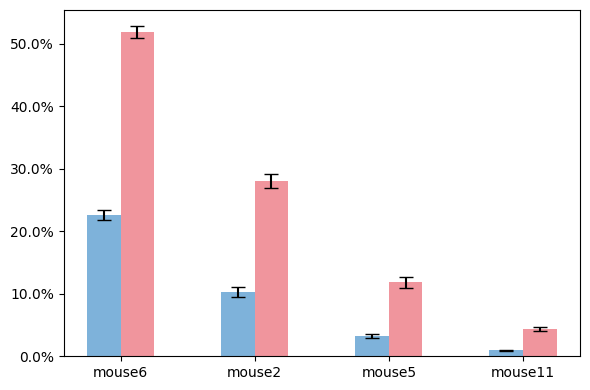

In [51]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def load_merged_results():
    """加载所有merged训练结果"""
    results_path = "/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/merged_train/"
    results = {}
    
    for mouse_name in ['mouse6', 'mouse2', 'mouse5', 'mouse11']:
        mouse_results = []
        
        # 加载每个老鼠的5次运行结果
        for run in range(1, 6):
            result_file = f"{results_path}{mouse_name}_run{run}_results.pkl"
            if os.path.exists(result_file):
                with open(result_file, 'rb') as f:
                    result = pickle.load(f)
                    mouse_results.append(result)
            else:
                print(f"警告: 文件不存在 {result_file}")
        
        if mouse_results:
            results[mouse_name] = mouse_results
        else:
            print(f"警告: {mouse_name} 没有找到任何结果文件")
    
    return results

def plot_merged_results_bar_chart():

    results = load_merged_results()
    mice = list(results.keys())
    top1_accs = []
    top5_accs = []
    top1_stds = []
    top5_stds = []
    
    for mouse in mice:
        mouse_results = results[mouse]
        top1_values = [r['best_test_acc'] for r in mouse_results]
        top5_values = [r['final_top5_acc'] for r in mouse_results]
        
        top1_mean = np.mean(top1_values)
        top5_mean = np.mean(top5_values)
        top1_std = np.std(top1_values)
        top5_std = np.std(top5_values)
        
        top1_accs.append(top1_mean)
        top5_accs.append(top5_mean)
        top1_stds.append(top1_std)
        top5_stds.append(top5_std)
        
        print(f"{mouse}: Top-1: {top1_mean:.2%} ± {top1_std:.2%}, Top-5: {top5_mean:.2%} ± {top5_std:.2%}")
    


    with PdfPages("/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/accuracy_merge.pdf") as pdf:
        fig, ax = plt.subplots(figsize=(6, 4))
        
        x = np.arange(len(mice))  
        width = 0.25  
        
        bars1 = ax.bar(x - width/2, top1_accs, width, label='Top-1 Accuracy', 
                    yerr=top1_stds, capsize=5, alpha=0.8, color='#5E9FD1')
        bars2 = ax.bar(x + width/2, top5_accs, width, label='Top-5 Accuracy', 
                    yerr=top5_stds, capsize=5, alpha=0.8, color='#ED7B85')

        ax.set_xticks(x)
        ax.set_xticklabels(mice)
        
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        plt.tight_layout()
        pdf.savefig()
        plt.show()
    
    return {
        'mice': mice,
        'top1_accs': top1_accs,
        'top5_accs': top5_accs,
        'top1_stds': top1_stds,
        'top5_stds': top5_stds
    }

stats = plot_merged_results_bar_chart()

In [48]:
# 绘图功能 - 分析month_sep_train结果
from matplotlib.backends.backend_pdf import PdfPages

def load_monthly_results():
    """加载所有monthly训练结果"""
    results_path = "/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/month_sep_train/"
    results = {}
    
    # 遍历所有老鼠的结果文件
    for mouse_name in ['mouse6', 'mouse5', 'mouse2', 'mouse11']:
        mouse_results = []
        
        # 查找该老鼠的所有结果文件
        pattern = f"{mouse_name}_month*_run*_results.pkl"
        import glob
        result_files = glob.glob(f"{results_path}{pattern}")
        
        for result_file in result_files:
            try:
                with open(result_file, 'rb') as f:
                    result = pickle.load(f)
                    mouse_results.append(result)
            except Exception as e:
                print(f"警告: 无法加载文件 {result_file}: {e}")
        
        if mouse_results:
            results[mouse_name] = mouse_results
            print(f"加载了 {mouse_name}: {len(mouse_results)} 个结果文件")
        else:
            print(f"警告: {mouse_name} 没有找到任何结果文件")
    
    return results

def plot_monthly_results_for_mouse(mouse_name, results):
    """为单只老鼠绘制monthly训练结果"""
    if not results:
        print(f"没有找到 {mouse_name} 的结果")
        return
    
    # 按月份分组结果
    monthly_data = {}
    for result in results:
        month = result['test_month']
        if month not in monthly_data:
            monthly_data[month] = {'top1': [], 'top5': []}
        
        monthly_data[month]['top1'].append(result['best_test_acc'])
        monthly_data[month]['top5'].append(result['final_top5_acc'])
    
    # 按照mouse_month中定义的顺序排序月份
    if mouse_name in mouse_month:
        ordered_months = mouse_month[mouse_name]
        # 只保留有数据的月份
        sorted_months = [month for month in ordered_months if month in monthly_data]
    else:
        # 如果没有找到对应的老鼠，按数字排序
        sorted_months = sorted(monthly_data.keys())
    
    # 准备绘图数据
    top1_means = []
    top1_stds = []
    top5_means = []
    top5_stds = []
    
    for month in sorted_months:
        data = monthly_data[month]
        top1_means.append(np.mean(data['top1']))
        top1_stds.append(np.std(data['top1']))
        top5_means.append(np.mean(data['top5']))
        top5_stds.append(np.std(data['top5']))
    
    pdf_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/{mouse_name}_monthly_results.pdf"
    
    with PdfPages(pdf_path) as pdf:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # 创建x轴位置
        x_pos = range(len(sorted_months))
        
        ax1.errorbar(x_pos, top1_means, yerr=top1_stds, 
                    marker='o', linewidth=2, markersize=8, capsize=5,
                    color='#5E9FD1', alpha=0.8, label='Top-1 Accuracy')
        ax1.set_title(f'{mouse_name} - Top-1 Accuracy Over Time', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Top-1 Accuracy', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        ax1.set_xticks([])

        # 绘制Top-5准确率
        ax2.errorbar(x_pos, top5_means, yerr=top5_stds, 
                    marker='s', linewidth=2, markersize=8, capsize=5,
                    color='#ED7B85', alpha=0.8, label='Top-5 Accuracy')
        ax2.set_title(f'{mouse_name} - Top-5 Accuracy Over Time', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Top-5 Accuracy', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        ax2.set_xticks([])
        
        
        # 调整布局
        plt.tight_layout()
        
        # 保存到PDF
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

    
    return {
        'months': sorted_months,
        'top1_means': top1_means,
        'top1_stds': top1_stds,
        'top5_means': top5_means,
        'top5_stds': top5_stds
    }

def plot_all_monthly_results():

    results = load_monthly_results()
    
    all_stats = {}
    
    for mouse_name, mouse_results in results.items():
        stats = plot_monthly_results_for_mouse(mouse_name, mouse_results)
        all_stats[mouse_name] = stats
    
    return all_stats

all_stats = plot_all_monthly_results()


加载了 mouse6: 70 个结果文件
加载了 mouse5: 75 个结果文件
加载了 mouse2: 55 个结果文件
加载了 mouse11: 95 个结果文件


In [59]:
# 修改后的绘图函数 - 单子图版本
def plot_monthly_results_for_mouse_single_plot(mouse_name, results):
    """为单只老鼠绘制monthly训练结果（单子图版本）"""
    if not results:
        print(f"没有找到 {mouse_name} 的结果")
        return
    
    # 按月份分组结果
    monthly_data = {}
    for result in results:
        month = result['test_month']
        if month not in monthly_data:
            monthly_data[month] = {'top1': [], 'top5': []}
        
        monthly_data[month]['top1'].append(result['best_test_acc'])
        monthly_data[month]['top5'].append(result['final_top5_acc'])
    
    # 按照mouse_month中定义的顺序排序月份
    if mouse_name in mouse_month:
        ordered_months = mouse_month[mouse_name]
        # 只保留有数据的月份
        sorted_months = [month for month in ordered_months if month in monthly_data]
    else:
        # 如果没有找到对应的老鼠，按数字排序
        sorted_months = sorted(monthly_data.keys())
    
    # 准备绘图数据
    top1_means = []
    top1_stds = []
    top5_means = []
    top5_stds = []
    
    for month in sorted_months:
        data = monthly_data[month]
        top1_means.append(np.mean(data['top1']))
        top1_stds.append(np.std(data['top1']))
        top5_means.append(np.mean(data['top5']))
        top5_stds.append(np.std(data['top5']))
    
    # 创建PDF文件
    pdf_path = f"/media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/{mouse_name}_monthly_results_single.pdf"
    
    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        
        # 创建x轴位置
        x_pos = range(len(sorted_months))
        
        # 绘制Top-1准确率
        ax.errorbar(x_pos, top1_means, yerr=top1_stds, 
                   marker='o', linewidth=2, markersize=6, capsize=5,
                   color='#5E9FD1', alpha=0.8, label='Top-1 Accuracy')
        
        # 绘制Top-5准确率
        ax.errorbar(x_pos, top5_means, yerr=top5_stds, 
                   marker='s', linewidth=2, markersize=6, capsize=5,
                   color='#ED7B85', alpha=0.8, label='Top-5 Accuracy')
        
        # 设置标题和标签
        ax.set_title(f'{mouse_name} - Accuracy Over Time', fontsize=14, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        ax.set_xticks([])
        

        plt.tight_layout()
        
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
    
    print(f"{mouse_name} 的单子图PDF已保存到: {pdf_path}")
    
    # 打印统计信息
    print(f"\n{mouse_name} 统计信息:")
    for i, month in enumerate(sorted_months):
        print(f"  月份 {month}: Top-1: {top1_means[i]:.2%} ± {top1_stds[i]:.2%}, "
              f"Top-5: {top5_means[i]:.2%} ± {top5_stds[i]:.2%}")
    
    return {
        'months': sorted_months,
        'top1_means': top1_means,
        'top1_stds': top1_stds,
        'top5_means': top5_means,
        'top5_stds': top5_stds
    }

def plot_all_monthly_results_single_plot():
    """为所有老鼠绘制monthly训练结果（单子图版本）"""
    # 加载结果
    results = load_monthly_results()
    
    if not results:
        print("没有找到任何monthly训练结果，请先运行训练")
        return
    
    all_stats = {}
    
    # 为每只老鼠绘制PDF
    for mouse_name, mouse_results in results.items():
        print(f"\n正在处理 {mouse_name}...")
        stats = plot_monthly_results_for_mouse_single_plot(mouse_name, mouse_results)
        all_stats[mouse_name] = stats
    
    return all_stats

# 执行绘图
print("开始绘制monthly训练结果（单子图版本）...")
all_stats_single = plot_all_monthly_results_single_plot()


开始绘制monthly训练结果（单子图版本）...
加载了 mouse6: 70 个结果文件
加载了 mouse5: 75 个结果文件
加载了 mouse2: 55 个结果文件
加载了 mouse11: 95 个结果文件

正在处理 mouse6...
mouse6 的单子图PDF已保存到: /media/ubuntu/sda/data/paper_architecture/02_consistency/train_results/mouse6_monthly_results_single.pdf

mouse6 统计信息:
  月份 22522: Top-1: 2.43% ± 0.45%, Top-5: 8.15% ± 0.67%
  月份 31722: Top-1: 5.54% ± 1.19%, Top-5: 16.89% ± 1.90%
  月份 42422: Top-1: 6.11% ± 0.66%, Top-5: 19.70% ± 1.29%
  月份 52422: Top-1: 10.77% ± 1.02%, Top-5: 30.09% ± 2.87%
  月份 62422: Top-1: 11.28% ± 0.96%, Top-5: 32.58% ± 1.86%
  月份 72322: Top-1: 18.44% ± 2.22%, Top-5: 45.26% ± 4.67%
  月份 82322: Top-1: 18.53% ± 1.41%, Top-5: 43.54% ± 2.21%
  月份 92422: Top-1: 20.43% ± 1.78%, Top-5: 48.72% ± 3.29%
  月份 102122: Top-1: 14.04% ± 1.75%, Top-5: 35.50% ± 0.87%
  月份 112022: Top-1: 14.74% ± 1.33%, Top-5: 38.96% ± 3.56%
  月份 122022: Top-1: 18.82% ± 1.09%, Top-5: 45.38% ± 2.05%
  月份 22223: Top-1: 17.52% ± 1.98%, Top-5: 40.63% ± 3.49%
  月份 32123: Top-1: 15.09% ± 2.00%, Top-5: 37.13% ± 